# The NAND Programming Language

_Version:_ 0.2

The NAND programming language was designed to accompany the upcoming book ["Introduction to Theoretical Computer Science"](http://introtcs.org). This is an appendix to this book, which is also available online as a Jupyter notebook in the  [boazbk/nandnotebooks](https://github.com/boazbk/nandnotebooks) on Github. You can also try the [live binder version](https://hub.mybinder.org/user/boazbk-nandnotebooks-221ipnov/notebooks/NAND%20programming%20language.ipynb).

The NAND programming language is part of a family of languages:

* __NAND:__  The NAND programming language is equivalent in expressive power to _Boolean circuits_. Specifically NAND programs are straightline programs with the _NAND_ operation, which are equivalent to Boolean circuits with _NAND_ gates.

* __NAND++:__ The NAND++ programming language is equivalent in expressive power to _Turing Machines_. NAND++ programs are obtained by adding _loops_ and _unbounded arrays_ to NAND programs. Specifically, NAND++ programs can be thought of as capturing _oblivious single tape Turing Machines_, that are polynomially equivalent to all other standard variants of Turing Machines and Turing-equivalent models of computation. 

* __NAND<<:__ The NAND<< programing language is a formalization of _RAM Machines_. NAND<< programs are obtained by adding integer-valued variables and arrays, and the standard "C type" operations on them, as well as _indirect indexing_ of arrays via integer variables. NAND<< programs are equivalent up to polylogarithmic terms to standard models of RAM machines, and up to polynomial terms with NAND++ and all other standard Turing-equivalent models.

* __QNAND:__ QNAND is only used in a single chapter of the book, and is meant to capture _Quantum Boolean Circuits_ and so can be used to define the class __BQP__ of polyonmial time quantum computaiton.


## Syntax of NAND programs 

This notebook/appendix is concerned with the first and simplest of these languages: the _NAND Programming Languages_. A NAND program consists of a sequence of lines, each of the following form:

```foo = NAND(bar,blah)```

where `foo`, `bar` and `blah` are variable identifiers. 

We have two special types of variables: _input variables_ have the form `X[` $i$ `]` where $i$ is a natural number, and _output variables_ have the form `Y[`$j$ `]` where $j$ is a natural number. When a NAND program is _executed_ on input $x \in \{0,1\}^n$, the variable `X[`$i$ `]` is assigned the value $x_i$ for all $i\in [n]$. The _output_ of the program is the list of $m$ values  `Y[0]`$\ldots$ `Y[`$m-1$ `]`, where $m-1$ is the largest index for which the variable `Y[`$m-1$ `]` is assigned a value in the program.

Here is an example of a NAND program:

In [2]:
xor = r'''
u = NAND(X[0],X[1]) 
v = NAND(X[0],u)
w = NAND(X[1],u)  
Y[0] = NAND(v,w)
'''

To evaluate this program on inputs $x_0,x_1 \in \{0,1\}$, we can use a simple _Python_ function that would keep track of the values assigned to variables. 

In [3]:
def NAND(x,y):
    """Compute the NAND of two 0/1 valued variables."""
    return 1 - x*y

In [4]:
import re

def EVAL(prog,x):
    """Evaluate NAND program prog on input x."""
    (n,m) = numinout(prog) # utility function to get num of inputs/outputs
    vartable = {} # dictionary for variables
    
    for i in range(n): vartable[f'X[{i}]']=x[i] # assign x[i] to variable "X[i]"
    
    for line in filter(None,prog.split('\n')): # split into lines, throw out empty ones
        # split to components of a line:
        foo,bar,blah, = filter(None,re.split('\s*=\s*NAND\s*\(\s*|\s*\,\s*|\s*\)\s*|\s+',line)) 
        vartable[foo] =  NAND(vartable[bar],vartable[blah])
    
    return [vartable[f'Y[{j}]'] for j in range(m)]

In [5]:
# IMPORTANT DISCLAIMER: 
# The code in this and other notebooks should not be considered as examples of good coding practice.
# Whenever faced with a choice, I picked simplicity of code or brevity over robustness.
# It is quite possible that running these functions with malformed inputs would trigger the Zombie apocalypse.

In [6]:
# utility function


def numinout(prog):
    '''Compute the number of inputs and outputs of a NAND program, given as a string of source code.'''
    n = max([int(s[2:-1]) for s in re.findall(r'X\[\d+\]',prog)])+1
    m = max([int(s[2:-1]) for s in re.findall(r'Y\[\d+\]',prog)])+1
    return n,m

numinout(xor)     

(2, 1)

In [7]:
EVAL(xor,[0,1])

[1]

## Specification of NAND Programming language

We now describe a NAND program a little more formally. Every line in a NAND program has the form

$id1$ `=`  `NAND(` $id2$ `,` $id3$ `)`

where $id1$,$id2$,$id3$ are _variable identifier_. A variable identifier is any sequence of letters, digits, and underscore and square bracket characters `_`,`[`,`]`.

Variables whose identifiers have the form `X[` $i$ `]` where $i$ is a sequence of digits are called _input variables_.

Variables whose identifiers have the form `Y[` $j$ `]` where $j$ is a sequence of digits are called _output variables_.

All variables in NAND are _Boolean_: the can only get the values $0$ and $1$. If a variable is accessed before it is assigned a value then we assume the value defaults to zero (however such accesses are not legal in _standard NAND programs_, see below).

### Execution of a NAND program

The _number of inputs_ of a NAND program $P$ is one plus the largest number $i$ such that a variable of the form `X[` $i$ `]` appears in $P$.
The _number of outputs_ of $P$ is one plus the largest number $j$ such that a variable of the form `Y[` $j$ `]` appears in $P$.

If $P$ is a program with $n$ inputs and $m$ outputs, then the _execution of $P$ on input $x\in \{0,1\}^n$ is defined as follows:

1. We assign to the variable `X[` $i$ `]` the value $x_i$ for all $i\in [n]$.

2. We execute line by line the program, where for each line of the form $id1$ `=`  `NAND(` $id2$ `,` $id3$ `)` we assign to the variable identified by $id1$ the NAND of the values of the variables identified by $id2$ and $id3$.

3. We output the $m$ values assigned to the variables `Y[` $0$ `]` $,\ldots,$ `Y[` $m-1$ `]`



### Standard or "well formed" NAND programs

We define the following as the "standard form" of a  NAND program: 

* While a priori variables can be any sequence of letters, digits, underscores and brackets, we will assume our identifiers have one of the following two forms:

   - A sequence of lower case letters, numbers, and underscores, that contain no upper case letters or brackets. For example `foo`, `bar_blah` , `hello_world` , `boaz1234`.
   
   - An identifier starting with a single capital letter, optionally followed by lower case letters, numbers, and underscores, and ending in `[` $i$ `]` where $i$ is a sequence of digits with no leading zeroes. For example `X[17]` or `Foo[22]` or `Bar_blah[103]`. 

* We will assume no variable is used before it is assigned a value. The output variables are never read from (i.e., never on the lefthand side of an assignment) and the input variables are never written to (i.e., never on the righthand side of an assignment).

* All output variables are written to, and all input variables are read from. That is, if a variable of the form `X[` $i$ `]` appears in the program then `X[` $i'$ `]` should also appear for all $0 \leq i' < i$. If a variable of the form `Y[` $j$ `]` appears in the program, then `Y[` $j'$ `]` should also appear for all $0 \leq j' < j$.

By default, every NAND program is assumed to be in standard form. Note that it is very easy to transform a NAND program into standard form, with a small cost in the number of lines. Specifically, we can ensure standard form by doing the following:

1. Modify variable names to fit out convention.
2. Add two lines to define a `zero` variable that is identically zero, and then use that in place of variables that haven't been assigned a value.
3. Add at most $n+m$ lines to touch all input and output variables.

For simplicity, we will often describe our results only for standard form NAND programs (for example the function `EVAL` above would throw an Exception if a variable is accessed before it's assigned a value), but they are of course easy to extend to general NAND programs through the transformation above.

## NAND interpreter via Python

While we could easily write a "NAND interpreter" in any programming language, by design a NAND program uses valid Python code. So we can also write NAND programs as python functions:

In [8]:
def XOR(a,b):
    t1 = NAND(a,b)
    t2 = NAND(a,t1)
    t3 = NAND(b,t1)
    return NAND(t2,t3)

XOR(0,1)

1

We can translate such a function into standard NAND code using a simple trick. 
The idea is that we evaluate the program "symbolically" giving it  as inputs the pair of _strings_ `X[0]` and `X[1]` instead of integers. 

In [9]:
XOR("X[0]","X[1]")

TypeError: can't multiply sequence by non-int of type 'str'

Of course we get a type error since `NAND` expects integers.
When we need to do is to  "override" the NAND function to take a pair of strings `bar`, `blah` instead of integers as input and generate the line of code `foo = NAND(bar,blah)` instead of computing the NAND function.

For example, the following almost works (except  the output variable is not of the right form `Y[` $j$ `]`)

In [11]:
count = 0

# Redfine NAND to take strings as input rather than integers
def NAND(bar,blah): 
    global count
    foo = f"Temp[{count}]"
    count +=1
    print(f"{foo} = NAND({bar},{blah}))")
    return foo

XOR("X[0]","X[1]")

Temp[0] = NAND(X[0],X[1]))
Temp[1] = NAND(X[0],Temp[0]))
Temp[2] = NAND(X[1],Temp[0]))
Temp[3] = NAND(Temp[1],Temp[2]))


'Temp[3]'

Let us fix the definition of `NAND` back to its right form, and then give a more robust version of a program that maps a Python function that implements a NAND program into the code/

In [12]:
def NAND(a,b): return 1-a*b

In [13]:
def nandcode(f):
    """
    Extract the NAND code of a given function f.
    Works by temporarily modifying NAND to take strings instead of integers,
    and generate on imput bar,blah a temporary variable identifier foo and the line
    'foo = NAND(bar,blah)'
    """
    n = numarguments(f)
    counter = 0 # to ensure unique temporary variables.
    code = ''
    
    def tempNAND(bar,blah):
        nonlocal code, counter 
        foo = f'Temp[{counter}]'
        counter += 1
        code += f'{foo} = NAND({bar},{blah})\n'
        return foo
    
    outputs = runwith(lambda : f(*[f'X[{i}]' for i in range(n)]),"NAND",tempNAND) 
    # execute f on the strings "X[0]", "X[1]", ... with NAND reassigned to tempNAND
    
    
    if type(outputs)==str: outputs = [outputs] # make single output into singleton list
        
    for j in range(len(outputs)):
        code = code.replace(outputs[j],f'Y[{j}]')
    return code

In [14]:
# Some utility functions 
# (can ignore on first read, uses not so important for us Python trickery)

from inspect import signature
def numarguments(f):
    """Number of arguments a Python function takes."""
    return len(signature(f).parameters)

def runwith(f,*args):
    """Evaluate function f binding name to func"""
    g = globals()
    old = {}
    new = {}
    for i in range(0,len(args),2):
        old[args[i]] = g[args[i]]
        new[args[i]] = args[i+1]
        # a little bit of an ugly hack 
        # if you know a nicer way, please let me know
    try:
        for name in new: g[name] = new[name]
        res = f()
    finally:
        for name in old: g[name] = old[name]
    return res

In [15]:
print(nandcode(XOR))

Temp[0] = NAND(X[0],X[1])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[1],Temp[0])
Y[0] = NAND(Temp[1],Temp[2])



In [16]:
XOR(1,1)

0

## Syntactic sugar

NAND is pretty bare bones, and writing NAND code directly gets real old real fast. However, we can use "syntactic  sugar" to make it a little less tedious. For example we can use function definitions to avoid copying again and again repetitive code.

We will use the Python-like syntax of `def func(...):` to define functions and so we can write the XOR on 4 bits function as follows:

In [17]:
def XOR4(a,b,c,d):
    return XOR(XOR(a,b),XOR(c,d))

XOR4(0,1,0,1)

0

To verify that this is indeed merely "syntactic sugar" and this can be translated to pure NAND we can use our `nandcode` function:

In [18]:
print(nandcode(XOR4))

Temp[0] = NAND(X[0],X[1])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[1],Temp[0])
Temp[3] = NAND(Temp[1],Temp[2])
Temp[4] = NAND(X[2],X[3])
Temp[5] = NAND(X[2],Temp[4])
Temp[6] = NAND(X[3],Temp[4])
Temp[7] = NAND(Temp[5],Temp[6])
Temp[8] = NAND(Temp[3],Temp[7])
Temp[9] = NAND(Temp[3],Temp[8])
Temp[10] = NAND(Temp[7],Temp[8])
Y[0] = NAND(Temp[9],Temp[10])



Once we have this, we can also define other functions such as AND, OR, NOT, and also the IF function that on input `cond`, `a` and `b` returns `a` if `cond` equals 1 and `b` otherwise.

In [19]:
def NOT(a):
    return NAND(a,a)

def AND(a,b):
    return NOT(NAND(a,b))

def OR(a,b):
    return NAND(NOT(a),NOT(b))

def IF(cond,first,sec):
    temp1 = AND(cond,first) # zero if cond=0, otherwise first
    temp2 = AND(NOT(cond),sec) # zero if cond=1, otherwise second
    return OR(temp1,temp2)

def one(a):
    return NAND(a,NOT(a))

def zero(a):
    return NOT(one(a))

def COPY(a):
    return NOT(NOT(a))

IF(0,1,0)

0

We can use more python-inspired syntactic sugar:

In [20]:
def increment(X): # increment integer given in binary representation
    n = len(X)
    Y = ["*"]*(n+1) # will be overwritten anyway
    carry = one(X[0])
    for i in range(n):
        Y[i] = XOR(X[i],carry)
        carry = AND(X[i],carry)
    Y[n] = COPY(carry)
    return Y

def inc5(a,b,c,d,e):
    return increment([a,b,c,d,e])

In [21]:
inc5(1,1,0,0,0)

[0, 0, 1, 0, 0, 0]

In [22]:
print(nandcode(inc5))

Temp[0] = NAND(X[0],X[0])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[0],Temp[1])
Temp[3] = NAND(X[0],Temp[2])
Temp[4] = NAND(Temp[1],Temp[2])
Y[0] = NAND(Temp[3],Temp[4])
Temp[6] = NAND(X[0],Temp[1])
Temp[7] = NAND(Temp[6],Temp[6])
Temp[8] = NAND(X[1],Temp[7])
Temp[9] = NAND(X[1],Temp[8])
Temp[10] = NAND(Temp[7],Temp[8])
Y[1] = NAND(Temp[9],Temp[10])
Temp[12] = NAND(X[1],Temp[7])
Temp[13] = NAND(Temp[12],Temp[12])
Temp[14] = NAND(X[2],Temp[13])
Temp[15] = NAND(X[2],Temp[14])
Temp[16] = NAND(Temp[13],Temp[14])
Y[2] = NAND(Temp[15],Temp[16])
Temp[18] = NAND(X[2],Temp[13])
Temp[19] = NAND(Temp[18],Temp[18])
Temp[20] = NAND(X[3],Temp[19])
Temp[21] = NAND(X[3],Temp[20])
Temp[22] = NAND(Temp[19],Temp[20])
Y[3] = NAND(Temp[21],Temp[22])
Temp[24] = NAND(X[3],Temp[19])
Temp[25] = NAND(Temp[24],Temp[24])
Temp[26] = NAND(X[4],Temp[25])
Temp[27] = NAND(X[4],Temp[26])
Temp[28] = NAND(Temp[25],Temp[26])
Y[4] = NAND(Temp[27],Temp[28])
Temp[30] = NAND(X[4],Temp[25])
Temp[31] = NAND(Temp[30],Temp[30

In [23]:
EVAL(nandcode(inc5),[1,0,1,0,0])

[0, 1, 1, 0, 0, 0]

We can create functions such as inc5 for every n via a little Python trickery:

In [24]:
def restrict(f,n):
    """Create function that restricts the function f to exactly n inputs"""
    args = ", ".join(f'arg{i}' for i in range(n))
    code =  rf'''
def _temp({args}):
    return f([{args}])
'''
    l = dict(locals())
    exec(code,l)
    return l["_temp"]

In [25]:

inc7 = restrict(increment,7)

inc7(1,1,1,0,0,0,1)

[0, 0, 0, 1, 0, 0, 1, 0]

In [26]:
print(nandcode(inc7))

Temp[0] = NAND(X[0],X[0])
Temp[1] = NAND(X[0],Temp[0])
Temp[2] = NAND(X[0],Temp[1])
Temp[3] = NAND(X[0],Temp[2])
Temp[4] = NAND(Temp[1],Temp[2])
Y[0] = NAND(Temp[3],Temp[4])
Temp[6] = NAND(X[0],Temp[1])
Temp[7] = NAND(Temp[6],Temp[6])
Temp[8] = NAND(X[1],Temp[7])
Temp[9] = NAND(X[1],Temp[8])
Temp[10] = NAND(Temp[7],Temp[8])
Y[1] = NAND(Temp[9],Temp[10])
Temp[12] = NAND(X[1],Temp[7])
Temp[13] = NAND(Temp[12],Temp[12])
Temp[14] = NAND(X[2],Temp[13])
Temp[15] = NAND(X[2],Temp[14])
Temp[16] = NAND(Temp[13],Temp[14])
Y[2] = NAND(Temp[15],Temp[16])
Temp[18] = NAND(X[2],Temp[13])
Temp[19] = NAND(Temp[18],Temp[18])
Temp[20] = NAND(X[3],Temp[19])
Temp[21] = NAND(X[3],Temp[20])
Temp[22] = NAND(Temp[19],Temp[20])
Y[3] = NAND(Temp[21],Temp[22])
Temp[24] = NAND(X[3],Temp[19])
Temp[25] = NAND(Temp[24],Temp[24])
Temp[26] = NAND(X[4],Temp[25])
Temp[27] = NAND(X[4],Temp[26])
Temp[28] = NAND(Temp[25],Temp[26])
Y[4] = NAND(Temp[27],Temp[28])
Temp[30] = NAND(X[4],Temp[25])
Temp[31] = NAND(Temp[30],Temp[30

## NAND Programs and circuits

NAND programs are equivalent to the model of Boolean circuits. We can present the graph corresponding to a NAND function using ideas similar to those we used to print the code

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [89]:
# Use schemdraw to visualize circuits
import SchemDraw as schem
import SchemDraw.elements as e
import SchemDraw.logic as l

def disp(self):
    self.draw()
    
schem.Drawing._ipython_display_ =  disp

In [219]:
# Schemdraw version
def sdnandcircuit(f):
    """Compute the graph representating a NAND circuit for a NAND program, given as a Python function."""
    n = numarguments(f)
    counter = 0 # to ensure unique temporary variables.
    G =   schem.Drawing(unit=.5,fontsize=8)
    curx,cury = 0,0
    def incr(jump = False):
        nonlocal curx, cury, n;
        UX = 2.5
        UY = 3.5
        if not jump and (cury>-UY*(n-1)):
            cury -= UY
        else:
            cury = 0
            curx = (curx // UX)*UX + UX
        
        if (curx): curx += abs(cury)*UX/(2*n*UY)
    
    nodes = {}
  
    def tempNAND(bar,blah):
        nonlocal G, counter, curx,cury
        var = f'Temp[{counter}]'
        counter += 1
        g = G.add(l.NAND2,xy=[curx,cury], d="right")#, label=var)
        incr()
        nodes[var] = g
        i1 = nodes[bar]
        in1 = i1.out if "out" in dir(i1)   else i1.end 
        i2 = nodes[blah]
        in2 = i2.out if "out" in dir(i2)   else i2.end 
        G.add(e.LINE,xy=in1,to=g.in1)
        G.add(e.LINE,xy=in2,to=g.in2)
        return var
    
    for i in range(n):
        nodes[f'X[{i}]'] = G.add(e.DOT, xy = [curx,cury], lftlabel=f'X[{i}]') 
        incr()
    
    
        
    outputs = runwith(lambda: f(*[f'X[{i}]' for i in range(n)]),'NAND',tempNAND)
    
    if type(outputs)==str: outputs = [outputs] # make single output into singleton list
        
    incr(True)
    for j in range(len(outputs)):
        g= nodes[outputs[j]]
        o =G.add(e.DOT,xy=[curx,cury],rgtlabel=f'Y[{j}]')
        G.add(e.LINE,xy=g.out,to=o.start)
        incr()
        
    return G

In [220]:
#Use Graphviz to visualize circuits
import graphviz
from graphviz import Graph
from graphviz import Digraph

In [221]:
#Graphviz version
def gvnandcircuit(f):
    """Compute the graph representating a NAND circuit for a NAND program, given as a Python function."""
    n = numarguments(f)
    counter = 0 # to ensure unique temporary variables.
    G =  Digraph(graph_attr= {"rankdir":"LR"}) # schem.Drawing(unit=.5)
  
    def tempNAND(bar,blah):
        nonlocal G, counter 
        var = f'Temp[{counter}]'
        counter += 1
        G.node(var,label="∧\u0305",shape='invhouse',orientation="90")
        G.edge(bar,var)
        G.edge(blah,var)
        return var
    
    for i in range(n):
        G.node(f'X[{i}]',label=f'X[{i}]', fontcolor='blue',shape='circle') 
        
    outputs = runwith(lambda: f(*[f'X[{i}]' for i in range(n)]),'NAND',tempNAND)
    
    if type(outputs)==str: outputs = [outputs] # make single output into singleton list
        
    for j in range(len(outputs)):
        G.node(outputs[j],label=f'Y[{j}]',fontcolor='red',shape='diamond')
    return G

In [267]:
def nandcircuit(f,method="Graphviz"):
    return gvnandcircuit(f) if method=="Graphviz" else sdnandcircuit(f)

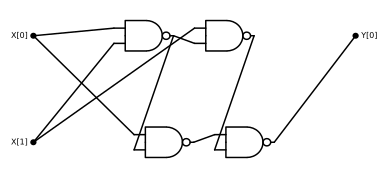

In [268]:
nandcircuit(XOR,"Schemdraw")

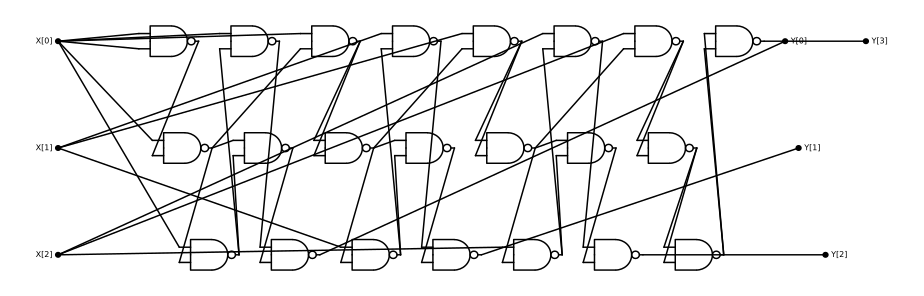

In [224]:
nandcircuit(restrict(increment,3))

## Computing every function

It turns out that we can compute _every_ function $f:\{0,1\}^n \rightarrow \{0,1\}$ by some NAND program.

The crucial element for that is the function `LOOKUP` that on input an index $i\in [n]$ (represented as a string of length $\log n$) and a table $T\in \{0,1\}^n$, outputs $t_i$.

In [225]:
def LOOKUP(T,i):
    l = len(i)
    if l==1:
        return IF(i[0],T[1],T[0])
    return IF(i[l-1],LOOKUP(T[2**(l-1):],i[:-1]),LOOKUP(T[:2**(l-1)],i[:-1]))

LOOKUP([0,1,1,0,1,1,0,1],[1,1,1])

1

In [226]:
# A more efficient IF .. not strictly necessary
def IF(cond,a,b):
    notcond = NAND(cond,cond)
    temp = NAND(b,notcond)
    temp1 = NAND(a,cond)
    return NAND(temp,temp1)

[f"{(a,b,c)}:{IF(a,b,c)}" for a in [0,1] for b in [0,1] for c in [0,1]]

['(0, 0, 0):0',
 '(0, 0, 1):1',
 '(0, 1, 0):0',
 '(0, 1, 1):1',
 '(1, 0, 0):0',
 '(1, 0, 1):0',
 '(1, 1, 0):1',
 '(1, 1, 1):1']

We can extract the NAND code of LOOKUP using the usual tricks.

In [227]:
# generalize restrict to handle functions that take more than one array
def restrict(f,*numinputs):
    """Create function that restricts the function f to exactly given input lengths n0,n1,..."""
    k = len(numinputs)
    args = []
    t = 0
    for i in range(k):
        if numinputs[i]: args = args + [", ".join(f'arg_{i}_{j}' for j in range(numinputs[i]))]
    sig = ", ".join(args)
    call = ", ".join(f"[{a}]" for a in args)
    code = rf'''
def _temp({sig}):
    return f({call})
'''
    l = dict(locals())
    exec(code,l)
    return l["_temp"]


In [228]:
def funclookup(l):
    return restrict(LOOKUP,2**l,l)

In [229]:
f = funclookup(3)
f

<function _temp(arg_0_0, arg_0_1, arg_0_2, arg_0_3, arg_0_4, arg_0_5, arg_0_6, arg_0_7, arg_1_0, arg_1_1, arg_1_2)>

In [230]:
f(1,0,1,1,1,1,0,1,1,0,1)

1

In [231]:
print(nandcode(funclookup(3)))

Temp[0] = NAND(X[8],X[8])
Temp[1] = NAND(X[6],Temp[0])
Temp[2] = NAND(X[7],X[8])
Temp[3] = NAND(Temp[1],Temp[2])
Temp[4] = NAND(X[8],X[8])
Temp[5] = NAND(X[4],Temp[4])
Temp[6] = NAND(X[5],X[8])
Temp[7] = NAND(Temp[5],Temp[6])
Temp[8] = NAND(X[9],X[9])
Temp[9] = NAND(Temp[7],Temp[8])
Temp[10] = NAND(Temp[3],X[9])
Temp[11] = NAND(Temp[9],Temp[10])
Temp[12] = NAND(X[8],X[8])
Temp[13] = NAND(X[2],Temp[12])
Temp[14] = NAND(X[3],X[8])
Temp[15] = NAND(Temp[13],Temp[14])
Temp[16] = NAND(X[8],X[8])
Temp[17] = NAND(X[0],Temp[16])
Temp[18] = NAND(X[1],X[8])
Temp[19] = NAND(Temp[17],Temp[18])
Temp[20] = NAND(X[9],X[9])
Temp[21] = NAND(Temp[19],Temp[20])
Temp[22] = NAND(Temp[15],X[9])
Temp[23] = NAND(Temp[21],Temp[22])
Temp[24] = NAND(X[10],X[10])
Temp[25] = NAND(Temp[23],Temp[24])
Temp[26] = NAND(Temp[11],X[10])
Y[0] = NAND(Temp[25],Temp[26])



In [232]:
[len(nandcode(funclookup(l)).split('\n'))/2**l for l in range(1,8,1)]

[2.5, 3.25, 3.625, 3.8125, 3.90625, 3.953125, 3.9765625]

## Representing NAND programs as lists of triples

We can represent a NAND program in many ways including  the string of its source code, as the graph corresponding to its circuit. One simple representation of a NAND program we will use is as the following:

We represent a NAND program of $t$ intermediate variables, $s$ lines, $n$ input variables, and $m$ input variables  as a triple $(n,m,L)$ where $L$ is a list of $s$ triples of the form $(a,b,c)$ of numbers in $[n+t+m]$. 

A triple $(a,b,c)$ corresponds to the line assigning to the variable corresponding $a$ the NAND of the variables corresponding to $b$ and $c$. We identify the first $n$ variables  with the input and the last $m$ variables with the outputs.

We can again compute this representation using Python:

In [233]:
def nandrepresent(f):
    """Compute the list of triple representation for a NAND program, given by a Python function."""
    n = numarguments(f)
    counter = n # to ensure unique temporary variables.
    L = [] # list of tuples
  
    
    def tempNAND(bar,blah):
        nonlocal L, counter 
        var = counter
        counter += 1
        L += [(var,bar,blah)] 
        return var
        
    outputs = runwith(lambda: f(*range(n)), "NAND", tempNAND) 
    
    if type(outputs)==int: outputs = [outputs] # make single output into singleton list
    m = len(outputs)
    
    # make sure outputs are last m variables
    for j in range(m):
        
        def flip(a):
            nonlocal counter, outputs, j
            if a==outputs[j]:  return counter+j
            return a
        
        L = [(flip(a),flip(b),flip(c)) for (a,b,c) in L]
                
    return (n,m,compact(L))

# utlity function
def compact(L):
    """Compact list of triples to remove unused variables."""
    s = sorted(set.union(*[set(T) for T in L]))
    return [ (s.index(a),s.index(b),s.index(c)) for (a,b,c) in L]


nandrepresent(XOR)

(2, 1, [(2, 0, 1), (3, 0, 2), (4, 1, 2), (5, 3, 4)])

We can directly evaluate a NAND program based on its list of triples representation:

In [234]:
def EVALnand(prog,X):
    """Evaluate a NAND program from its list of triple representation."""
    n,m,L = prog
    vartable = X+[0]*(max(max(a,b,c) for (a,b,c) in L)-n+1)
    for (a,b,c) in L:
        vartable[a] = NAND(vartable[b],vartable[c])
    
    return [vartable[-m+j] for j in range(m)]

In [235]:
EVALnand(nandrepresent(XOR),[1,1])

[0]

### Pruning (optional)


We can do some simple transformations to reduce the size of our programs/circuits. For example, if two gates have exactly the same inputs then we can identify them with one another.
We can also use the equality NOT(NOT(a))=a, as well as remove unused variables.


In [236]:
def prune(prog):
    """Prune representation of program as tuples, removing duplicate lines and unused variables."""
    n,m,L = prog
    L = list(L)
    def identify(L,e,f):
        # identify vertex e with vertex f
        def ident(k): 
            nonlocal e,f
            return f if k==e else k
        
        return [(ident(a),ident(b),ident(c)) for (a,b,c) in L]
    
    
    
    t = max([max(a,b,c) for (a,b,c) in L])+1

    
    while True:
        neighborhood = {}
        neighbors = {}
        
        found = False 
        for (a,b,c) in L:
            N = frozenset([b,c])
            if a>=t-m: continue # don't remove output variables
            if N in neighborhood: # there was prior duplicate line
                L.remove((a,b,c))
                L = identify(L,a,neighborhood[N])
                found = True
                break
            if b==c and b in neighbors and len(neighbors[b])==1: # line is NOT of NOT of prior line
                L.remove((a,b,c))
                L = identify(L,a,next(iter(neighbors[b])))
                found = True
                break
            neighborhood[N] = a
            neighbors[a] = N
            
        touched   = {a: False for a in range(t)} 
        for (a,b,c) in L: 
            touched[b] = True
            touched[c] = True

        for d in range(n,t-m,1): # remove non output and input variables that are not used
            if not touched[d]: 
                for (a,b,c) in L:
                    if a==d:
                        L.remove((a,b,c))
                        found =True
        if not found: break
    
    return (n,m,compact(L))        
        
    

### Some examples

In [237]:
# Majority
def MAJ(a,b,c): return NAND(NAND(NAND(NAND(a,b),NAND(a,c)),NAND(NAND(a,b),NAND(a,c))),NAND(b,c))

# Integer addition of two n bit numbers
def ADD(A,B):
    n = len(A)
    Result = [0]*(n+1)
    Carry  = [0]*(n+1)
    Carry[0] = zero(A[0])
    for i in range(n):
        Result[i] = XOR(Carry[i],XOR(A[i],B[i]))
        Carry[i+1] = MAJ(Carry[i],A[i],B[i])
    Result[n] = Carry[n]
    return Result



In [238]:
f = restrict(ADD,2,2)
P = nandrepresent(f)

In [239]:
all([(f(a,b,c,d)==EVALnand(prune(P),[a,b,c,d])) for a in [0,1] for b in [0,1] for c in [0,1] for d in [0,1] ])

True

## From representation to code or graph

We can use the list of triples representation as a starting point to obtain the NAND program as a list of lines of code, or as a circuit (i.e., directed acyclic graph).

In [316]:
# Graphviz version
def gvrep2circuit(P):
    """Return circuit (i.e., graph) corresponding to NAND program P given in list of tuples representation."""
    
    n,m,L = P
    G = Digraph(graph_attr= {"rankdir":"LR"})
  
    for i in range(n):
        G.node(f"v{i}",label=f'X[{i}]', fontcolor='blue',shape='square')
    
    t = n
    
    for (a,b,c) in L:
        G.node(f"v{a}",shape="none",image='NAND_gate.png') #,orientation="90")
        G.edge(f"v{b}",f"v{a}")
        G.edge(f"v{c}",f"v{a}")
        t = max(t,a,b,c)

    t += 1
    for j in range(m):
        G.node(f"v{t-m+j}",label=f'Y[{j}]',fontcolor='red',shape='diamond')
    
    return G
    

In [317]:

    

# Schemdraw version
def sdrep2circuit(P):
    """Return circuit (i.e., graph) corresponding to NAND program P given in list of tuples representation."""
    
    n,m,L = P
    G =   schem.Drawing(unit=.5,fontsize=8)
    curx,cury = 0,0
    def incr(jump = False):
        nonlocal curx, cury, n;
        UX = 2.5
        UY = 3.5
        if not jump and (cury>-UY*(n-1)):
            cury -= UY
        else:
            cury = 0
            curx = (curx // UX)*UX + UX
        
        if (curx): curx += abs(cury)*UX/(2*n*UY)
    
    nodes = {}
  
    for i in range(n):
        nodes[f'v{i}'] = G.add(e.DOT, xy = [curx,cury], lftlabel=f'X[{i}]') 
        incr()
        
        
    t = n
    
    for (a,b,c) in L:
        var = f"v{a}"
        g = G.add(l.NAND2,xy=[curx,cury], d="right")#, label=var)
        incr()
        nodes[var] = g
        i1 = nodes[f"v{b}"]
        in1 = i1.out if "out" in dir(i1)   else i1.end 
        i2 = nodes[f"v{c}"]
        in2 = i2.out if "out" in dir(i2)   else i2.end 
        G.add(e.LINE,xy=in1,to=g.in1)
        G.add(e.LINE,xy=in2,to=g.in2)
        t = max(t,a,b,c)

    t += 1
    
    incr(True)
    for j in range(m):
        g= nodes[f"v{t-m+j}"]
        o =G.add(e.DOT,xy=[curx,cury],rgtlabel=f'Y[{j}]')
        G.add(e.LINE,xy=g.out,to=o.start)
        incr()  
    
    return G

In [318]:
def rep2circuit(P,method="Graphviz"):
    return gvrep2circuit(P) if method=="Graphviz" else sdrep2circuit(P)

In [320]:
G = gvrep2circuit(P)
G.render()

'Digraph.gv.pdf'

In [300]:
G.render(filename="temp")

'temp.pdf'

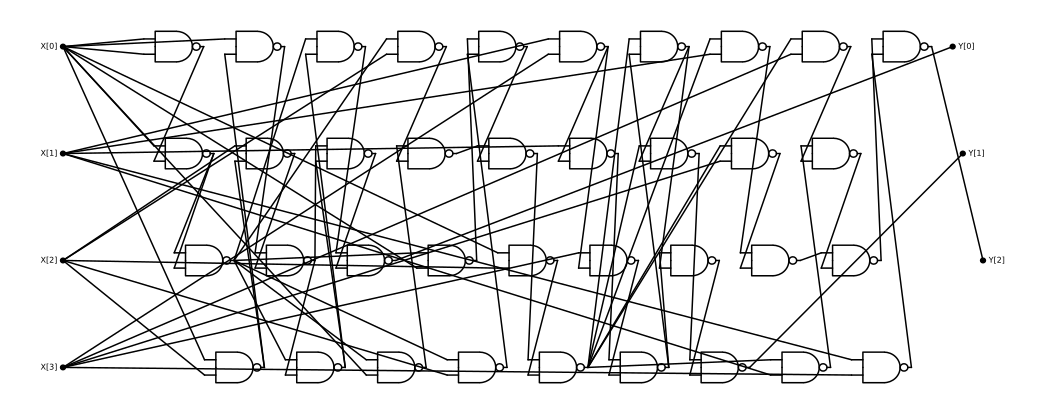

In [276]:
sdrep2circuit(P)

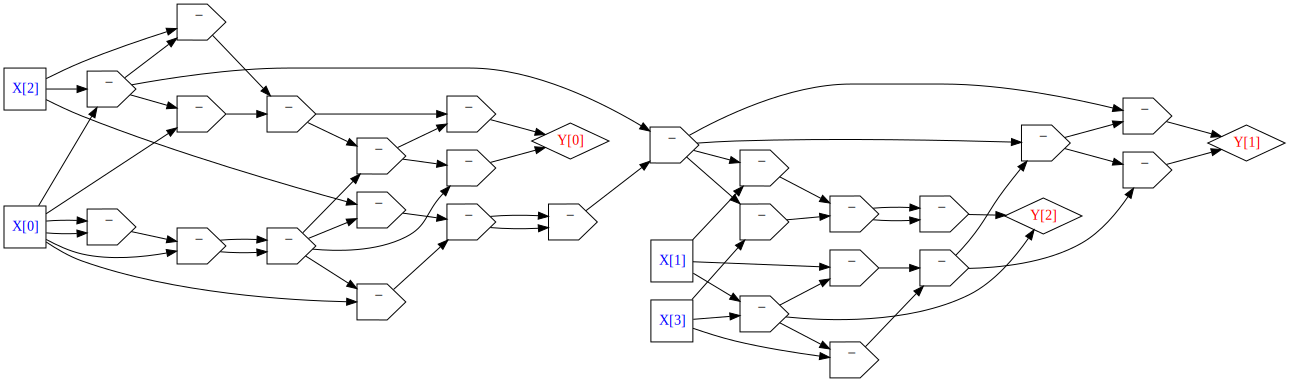

In [277]:
rep2circuit(prune(P))

In [273]:
def rep2code(P):
    """Return NAND code corresponding to NAND program P, given in list of tuples representation"""
    n,m,L = P
    code = ""
  
    t = max([max(a,b,c) for (a,b,c) in L])+1
    
    def var(a):
        if a<n: return f"X[{a}]"
        if a>=t-m: return f"Y[{a-t+m}]"
        return f"Temp[{a-n}]"
    
    for (a,b,c) in L:
        code += f"\n{var(a)} = NAND({var(b)},{var(c)})"

    return code

We can now redefine the `nandcircuit` and  `nandcode` functions to work as follows:

1. First  obtain the list of triples representation
2. Then prune it
3. Then transform it to either code or circuit appropriately

In [280]:
def nandcode(f):
    return rep2code(prune(nandrepresent(f)))

def nandcircuit(f, method="Graphviz"):
    return rep2circuit(prune(nandrepresent(f)),method)

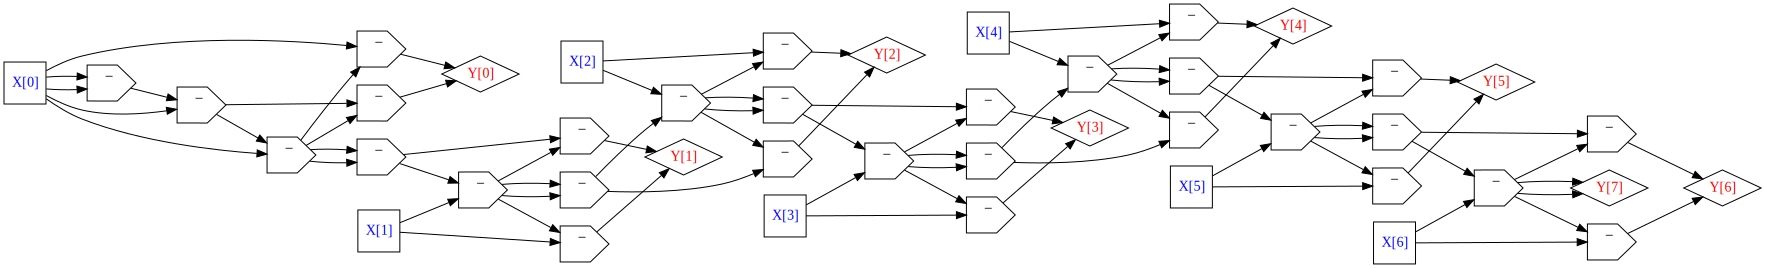

In [281]:
nandcircuit(inc7,"Graphviz")

## Universal circuit evaluation or NAND interpreter in NAND

We can construct a NAND program $P$ that given the representation of a NAND program $Q$ and an input $x$, outputs $Q(x)$. We can obviously compute such a function since every finite function is computable by a NAND program, but it turns out we can do so in a program that is polynomial in the size of $P$ (even quasiliinear but we won't show that here). 


We start with a reimplementation of `NANDEVAL` in Python:

In [51]:
def GET(V,i): return V[i]

def UPDATE(V,i,b):
    V[i]=b
    return V


def NANDEVAL(n,m,L,X):
    # Evaluate a NAND program from its list of triple representation.
    s = len(L) # number of lines
    t = max(max(a,b,c) for (a,b,c) in L)+1 # maximum index in L + 1

    Vartable = [0] * t # we'll simply use an array to store data

    

    # load input values to Vartable:
    for i in range(n): Vartable = UPDATE(Vartable,i,X[i])

    # Run the program
    for (i,j,k) in L:
        a = GET(Vartable,j)
        b = GET(Vartable,k)
        c = NAND(a,b)
        Vartable = UPDATE(Vartable,i,c)

    # Return outputs Vartable[t-m], Vartable[t-m+1],....,Vartable[t-1]
    return [GET(Vartable,t-m+j) for j in range(m)]


In [52]:
L = ((2, 0, 1), (3, 0, 2), (4, 1, 2), (5, 3, 4))
print(NANDEVAL(2,1,L,(0,1))) # XOR(0,1)

print(NANDEVAL(2,1,L,(1,1))) # XOR(1,1)

[1]
[0]


Now transform this to work with the representation of `L` as a binary string, namely as a sequence of $3s$ numbers in $[t]$, each represented as a string of length $\ell = \lceil \log 3s \rceil$.

In [53]:
from math import ceil, floor, log2
def triplelist2string(L):
    """Transform list of triples into its representation as a binary string"""
    s = len(L)
    ell = ceil(log2(3*s))
    B = [0]*(3*s*ell)
    FlatL = [a for T in L for a in T]
    for i in range(3*s):
        for j in range(ell):
            B[ell*i + j] = floor(FlatL[i]/ 2**j) % 2
    return B

### Evaluating a NAND program given its string representation

We can now present `NANDEVALBIN`  which will be a Python function that evaluates a NAND program given the representation of the program as a binary string. (We assume the parameters $n,m,s,t$ are given: we could have assumed they are part of the string representation, but this only makes things messier.)

In [54]:

def NANDEVALBIN(n,m,s,t,B,X):
    """Evaluate nand program given its description as a binary array"""

    ell = ceil(log2(3*s))
    Vartable = [0] * (2**ell) # we'll simply use an array to store data
    
    # load input values to Vartable:
    for i in range(n): Vartable[i] = X[i] 

    # Run the program
    for c in range(s):
        i = [B[c*3*ell+d] for d in range(ell)]
        j = [B[c*3*ell+ell+d] for d in range(ell)]
        k = [B[c*3*ell+2*ell+d] for d in range(ell)]
        a = GETB(Vartable,j)
        b = GETB(Vartable,k)
        c = NAND(a,b)
        Vartable = UPDATEB(Vartable,i,c)

    # Return outputs Vartable[t-m], Vartable[t-m+1],....,Vartable[t-1]
    return [Vartable[t-m+j] for j in range(m)]
    

We'll need some utility functions to deal with the binary representation (you can ignore these at a first read)

In [55]:
# utility functions
def nandconst(b,x):
    """Transform 0 or 1 to NAND zero or one functions"""
    if b: return one(x)
    return zero(x)

def i2s(i,ell=0):
    """Transform integer to binary representation of length ell"""
    if not ell: ell = ceil(log2(i))
    return [floor(i/2**j) %2  for j in range(ell)]

def GETB(V,i):
    return LOOKUP(V,i)

def EQUALB(j,i):
    flag = zero(i[0]) # if flag is one then i is different from j
    for t in range(len(j)):
        if type(j[t])==int:
            temp = NOT(i[t]) if j[t] else COPY(i[t])
        else:
            temp = OR(AND(j[t],NOT(i[t])),AND(NOT(j[t]),i[t]))
        flag = OR(temp,flag)
    return NOT(flag)

def UPDATEB(V,i,b):
    ell = ceil(log2(len(V)))
    UV = [0]*len(V)
    for j in range(len(V)):
        a = EQUALB(i2s(j,ell),i)
        UV[j] = IF(a,b,V[j])
    
    return UV
    

Now let's test this out on the XOR function

In [56]:
n,m,L = nandrepresent(XOR)
s = len(L)
t = max(max(T) for T in L)+1
XORstring = triplelist2string(L)

In [57]:
NANDEVALBIN(n,m,s,t,XORstring,[0,1])

[1]

In [58]:
NANDEVALBIN(n,m,s,t,XORstring,[1,1])

[0]

We can also try this on the XOR of 4 bits

In [59]:
def XOR4(a,b,c,d): return XOR(XOR(a,b),XOR(c,d))
n,m,L = nandrepresent(XOR4)
s = len(L)
t = max(max(T) for T in L)+1
XOR4string = triplelist2string(L)

In [60]:
NANDEVALBIN(n,m,s,t,XOR4string,[0,1,0,1])

[0]

In [61]:
NANDEVALBIN(n,m,s,t,XOR4string,[0,1,1,1])

[1]

### From Python to NAND

We now transform the Python program NANDEVALBIN into a NAND program.
In fact, it turns out that all our python code can be thought of as "syntacic sugar" and hence we can do this transformation automatically.

Specifically, for every numbers $n,m,s,t$  we will construct a NAND program $P$ on $3s\ell+n$ inputs (for $\ell = \lceil \log_2(3s) \rceil$ that on input a string $B\in \{0,1\}^{3s\ell}$ and $x\in \{0,1\}^n$  outputs $P(x)$ where $P$ is the program represented by $B$.

To do so, we simply first restrict `NANDEVALBIN` to the parameters $n,m,s,t$ and then run our usual "unsweetener" to extract the NAND code from it

In [62]:
def nandevalfunc(n,m,s,t):
    """Given n,m,s,t, return a function f that on input B,X returns the evaluation of the program encoded by B on X"""
    ell = ceil(log2(3*s))
    return restrict(lambda B,X: NANDEVALBIN(n,m,s,t,B,X),3*s*ell,n)


For example, let us set $n,m,s,t$ to be the parameters as in the XOR function

In [63]:
n,m,L = nandrepresent(XOR)
s = len(L)
t = max(max(T) for T in L)+1
XORstring = triplelist2string(L)

In [64]:
f = nandevalfunc(n,m,s,t)

In [65]:
f(*(XORstring+[0,1]))

[1]

In [66]:
f(*(XORstring+[1,1]))

[0]

`f` above is still a Python function, but we now transform it into a NAND function

In [67]:
nand_eval_in_nand = nandrepresent(f)

And test it out

In [68]:
NANDEVAL(*nand_eval_in_nand,XORstring+[1,0])

[1]

It is important to note that `nand_eval_in_nand` is not specific to the XOR function: it will evaluate _any_ NAND program of the given parameters $n,m,s,t$. Some "hardwiring" of parameters is inherently needed since NAND programs only take a fixed number of inputs. 

We could have also generated a NAND program that computes $t$ from the other parameters. We just avoided it because it's a little more cumbersome.

Let's see that this doesn't work out just for XOR

In [69]:
n,m,L = nandrepresent(restrict(increment,1))

In [70]:
s = len(L)
t = max(max(T) for T in L)+1
(s,t)

(10, 11)

In [71]:
f = nandevalfunc(n,m,s,t)

In [72]:
inc_string = triplelist2string(nandrepresent(restrict(increment,1))[2])

In [73]:
f(*(inc_string+[1]))

[0, 1]

In [74]:
nand_eval_in_nand = nandrepresent(f)

In [75]:
NANDEVAL(*nand_eval_in_nand,inc_string+[1])

[0, 1]

In [76]:
restrict(increment,1)(1)

[0, 1]

### Version of Python used in this notebook

In [67]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
